## Import Necessary Libs

In [1]:
import pandas as pd
import os
import numpy as np
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm
import wandb
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output  # to display images
from PIL import Image 
from os import listdir
from os.path import isfile
from glob import glob
import yaml
import torch
import matplotlib.pyplot as plt

## Define PATHs

In [2]:
TRAIN_LABELS_PATH = './vinbigdata/labels/train'
VAL_LABELS_PATH = './vinbigdata/labels/val'
TRAIN_IMAGES_PATH = './vinbigdata/images/train'
VAL_IMAGES_PATH = './vinbigdata/images/val'
External_DIR = '../input/vinbigdata-512-image-dataset/vinbigdata/train'
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

# image size to be put into YOLOv5
size = 256

In [3]:
%cd /Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models
%pwd

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models


'/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models'

## Observe Dataset

In [4]:
df = pd.read_csv('../input/vinbigdata-512-image-dataset/vinbigdata/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


In [5]:
df.shape

(67914, 10)

In [6]:
len(df['image_id'].unique())

15000

In [7]:
print(df['class_name'].value_counts())

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64


## Remove "No finding" Rows

In [8]:
df = df[df['class_id']!=14].reset_index(drop = True)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


In [9]:
df['image_id'].value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
3a302fbbbf3364aa1a7731b59e6b98ec    46
6d5acf3f8a973a26844d617fffe72998    46
                                    ..
6b2b72d289bf26b3aaf41548df0ab160     3
7e6182876c0a09e96176348e2fcd712e     3
4e05e0eb20d51d18764289ce2c240942     3
af274ab115b34a7c0eca41ed997fd214     3
1224f07d895107573588225f692e94f9     3
Name: image_id, Length: 4394, dtype: int64

## Calc bounding box in YOLOv5 format

In [10]:
# resize
df['x_min'] = df.apply(lambda row: (row.x_min)/row.width, axis = 1)*float(size)
df['y_min'] = df.apply(lambda row: (row.y_min)/row.height, axis = 1)*float(size)
df['x_max'] = df.apply(lambda row: (row.x_max)/row.width, axis =1)*float(size)
df['y_max'] = df.apply(lambda row: (row.y_max)/row.height, axis =1)*float(size)

df['x_mid'] = df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

df['w'] = df.apply(lambda row: (row.x_max-row.x_min), axis =1)
df['h'] = df.apply(lambda row: (row.y_max-row.y_min), axis =1)

df['x_mid'] /= float(size)
df['y_mid'] /= float(size)

df['w'] /= float(size)
df['h'] /= float(size)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,85.046154,150.684932,203.446154,200.657534,2080,2336,0.563462,0.686216,0.462500,0.195205
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,140.444444,66.044444,179.000000,90.577778,2304,2880,0.623915,0.305903,0.150608,0.095833
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,63.193701,29.750000,95.445669,36.083333,2540,3072,0.309843,0.128581,0.125984,0.024740
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,150.911160,24.547945,245.132604,217.324462,2285,2555,0.773523,0.472407,0.368053,0.753033
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,55.526480,179.574113,67.289720,189.652252,2568,3353,0.239875,0.721145,0.045950,0.039368


In [11]:
df.shape

(36096, 14)

## Select Cardiomegaly and Pleural thickening

In [12]:
cardiomegaly_df = df[df['class_id'] == 3][0:2000].copy()
pleural_df = df[df['class_id'] == 11][0:2000].copy()


In [13]:
print(cardiomegaly_df.shape)
print(pleural_df.shape)

(2000, 14)
(2000, 14)


## TRAIN and VAL split

In [14]:
c_train = cardiomegaly_df[0:1800].copy()
c_val = cardiomegaly_df[1800:].copy()
p_train = pleural_df[0:1800].copy()
p_val = pleural_df[1800:].copy()

In [15]:
train_df = pd.concat([c_train, p_train])
val_df = pd.concat([c_val, p_val])

In [16]:
train_df['class_id'] = train_df['class_id'].replace(3, 0)
train_df['class_id'] = train_df['class_id'].replace(11, 1)
val_df['class_id'] = val_df['class_id'].replace(3, 0)
val_df['class_id'] = val_df['class_id'].replace(11, 1)

In [17]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [18]:
print(df.shape)
print(train_df.shape)
print(val_df.shape)

(36096, 14)
(3600, 14)
(400, 14)


## Convert to YOLOv5 format

In [19]:
# <class> <x_center> <y_center> <width> <height>
def preproccess_data(df, labels_path, images_path):
	for index, row in tqdm(df.iterrows(), total=len(df)):
		attributes = row[['class_id','x_mid','y_mid','w','h']].values
		attributes = np.array(attributes)
		np.savetxt(os.path.join(labels_path, f"{row['image_id']}-{index}.txt"), [attributes], fmt = ['%d', '%f', '%f', '%f', '%f'])
		image = Image.open(os.path.join('../input/vinbigdata-512-image-dataset/vinbigdata/train', f"{row['image_id']}.png"))
		resizedImage = image.resize((size, size))
		resizedImage.save(images_path + f"/{row['image_id']}-{index}.png")

In [20]:
# preproccess_data(train_df, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
# preproccess_data(val_df, VAL_LABELS_PATH, VAL_IMAGES_PATH)

## YOLOv5 Configuration

In [21]:
# classes = train_df['class_name'].unique().tolist()

# data = dict(
#     train =  '../vinbigdata/images/train',
#     val   =  '../vinbigdata/images/val',
#     nc    = len(classes),
#     names = classes
#     )

# with open('./yolov5/vinbigdata.yaml', 'w') as outfile:
#     yaml.dump(data, outfile, default_flow_style=False)

f = open('./yolov5/vinbigdata.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Cardiomegaly
- Pleural thickening
nc: 2
train: ../vinbigdata/images/train
val: ../vinbigdata/images/val



## YOLOv5 Training

In [22]:
# !git clone https://github.com/ultralytics/yolov5.git

In [23]:
%cd yolov5

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models/yolov5


In [24]:
# %pip install -U -r requirements.txt
# %pip install pycocotools seaborn pandas thop

# # clear_output()

In [25]:
# wandb.login()

In [26]:
# !wandb offline

In [27]:
# !python train.py --img 256 --batch 16 --epochs 100 --patience 20 --data ./vinbigdata.yaml --cfg models/yolov5l.yaml --weights yolov5l.pt --cache --name vin

## Model Testing

In [28]:
%cd ..

/Users/teeradejlo/Desktop/Projects/DataScience/Bas_CXRAnomalyDetection/models


In [29]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path="./yolov5/runs/train/vin2/weights/best.pt")

Using cache found in /Users/teeradejlo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-30 Python-3.8.13 torch-1.13.1 CPU

Fusing layers... 
YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


In [30]:
test_cardiomegaly_df = df[df['class_id'] == 3][2000:2005].copy()
test_pleural_df = df[df['class_id'] == 11][2000:2005].copy()

test_df = pd.concat([test_cardiomegaly_df, test_pleural_df])

In [31]:
imgs = [os.path.join('../input/vinbigdata-512-image-dataset/vinbigdata/train', f"{f}.png") for f in test_df['image_id']]

In [32]:
results = model(imgs)

In [33]:
r_img = results.render()

In [34]:
r_img = [ Image.fromarray(arr) for arr in r_img ]

In [35]:
test_df = test_df.reset_index(drop=True)

In [36]:
test_df

,image_id,class_name,class_id,rad_id,x_min,...,height,x_mid,y_mid,w,h
0,c5eb5f71bfa01fe274e5f6a19f6006ed,Cardiomegaly,3,R9,81.888889,...,2880,0.537543,0.601562,0.435330,0.071875
1,4a46cdf01cee2a200f00daedf11576a9,Cardiomegaly,3,R10,94.707179,...,2810,0.579132,0.710142,0.418364,0.144840
2,0ca7c951e2298b9aad37ae0deb4d2a92,Cardiomegaly,3,R8,93.184751,...,2602,0.577529,0.633935,0.427053,0.164105
3,2a7a75a118e112a3b655617f77a3009a,Cardiomegaly,3,R10,85.888889,...,2880,0.540365,0.520139,0.409722,0.091667
4,ada5ba2e729f9b4518de5a6bc31e1eca,Cardiomegaly,3,R8,70.266284,...,2784,0.570053,0.722701,0.591151,0.210489
5,aac7be2bd0b4a2eeea474ffeac78ad13,Pleural thickening,11,R9,25.062359,...,3293,0.120032,0.814759,0.044265,0.055876
6,e67e4cab40626c54b8fc20ce6e9e4273,Pleural thickening,11,R9,237.000000,...,2500,0.944824,0.688000,0.038086,0.063200
7,aa89a83d50a147e44d6dc72893f01fef,Pleural thickening,11,R9,164.222222,...,2880,0.718533,0.195833,0.154080,0.102083
8,44999de3c6dd3312011578cdbfc7116e,Pleural thickening,11,R10,77.754386,...,3188,0.383955,0.110885,0.160453,0.049247
9,a946684583c7bf346b18e1d69d17e9cf,Pleural thickening,11,R10,51.757387,...,2988,0.303072,0.155288,0.201788,0.088353


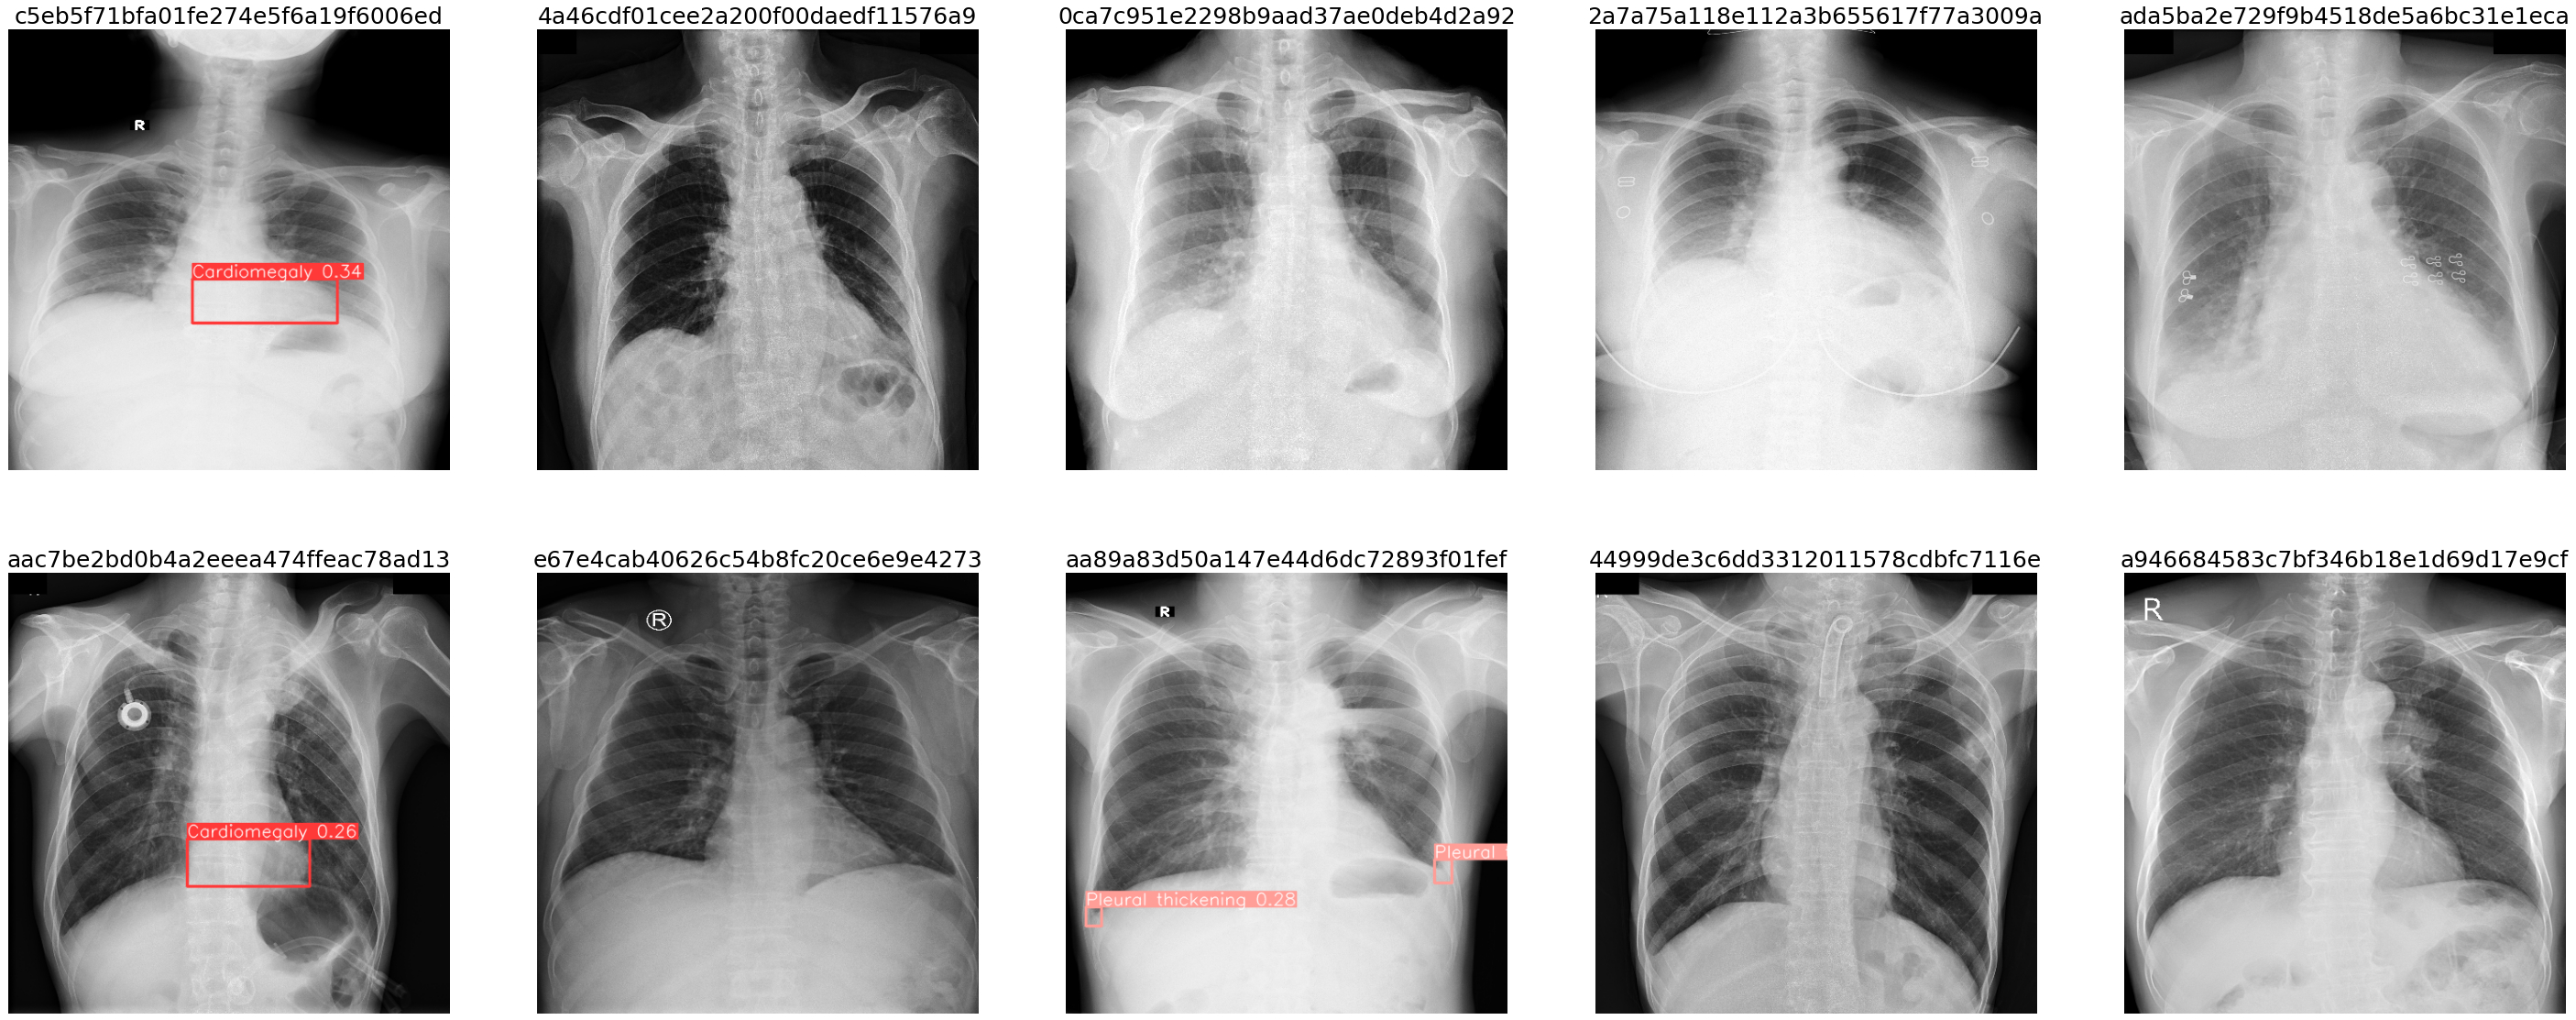

In [37]:
%matplotlib inline
f, ax = plt.subplots(2,5, figsize=(50,20))

for index, img in enumerate(r_img):
	ax[int(index / 5), index % 5].imshow(img)
	ax[int(index / 5), index % 5].axis('off')
	ax[int(index / 5), index % 5].set_title(test_df['image_id'][index], fontsize=25)


In [38]:
for row in test_df.index:
	labels, cord_thres = results.xyxyn[row][:, -1].numpy(), results.xyxyn[row][:, :-1].numpy()
	print("Image_ID:", test_df['image_id'][index])
	if (len(labels)==0):
		print("\tNot Found")
		continue
	for index, label in enumerate(labels):
		print("\tClass:", "Cardiomegaly" if label == 0 else "Pleural thickening")
		print("\txmin:", cord_thres[index][0])
		print("\tymin:", cord_thres[index][1])
		print("\txmax:", cord_thres[index][2])
		print("\tymax:", cord_thres[index][3])
		print("\tconf:", cord_thres[index][4])

Image_ID: a946684583c7bf346b18e1d69d17e9cf
	Class: Cardiomegaly
	xmin: 0.416286
	ymin: 0.567668
	xmax: 0.74458456
	ymax: 0.6672162
	conf: 0.3372109
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Not Found
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Not Found
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Not Found
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Not Found
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Class: Cardiomegaly
	xmin: 0.40546933
	ymin: 0.60373485
	xmax: 0.6825803
	ymax: 0.71271324
	conf: 0.25505933
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Not Found
Image_ID: c5eb5f71bfa01fe274e5f6a19f6006ed
	Class: Pleural thickening
	xmin: 0.83537257
	ymin: 0.6505279
	xmax: 0.8737408
	ymax: 0.7035485
	conf: 0.30982363
	Class: Pleural thickening
	xmin: 0.04548373
	ymin: 0.75822777
	xmax: 0.08026226
	ymax: 0.8018861
	conf: 0.27915663
Image_ID: 4a46cdf01cee2a200f00daedf11576a9
	Not Found
Image_ID: 4a46cdf01cee2a200f00daedf11576a9
	Not Found


In [39]:
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,213.138428,290.646027,381.227295,341.614685,0.337211,0,Cardiomegaly
